In [2]:
import pandas as pd 
import numpy as np
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [96]:
df = pd.read_csv("C:/Users/hanna/Scape-Save-DAEN690/Datasets/indeed_cleaned.csv.gz") 
cos_df = pd.read_excel("C:/Users/hanna/Scape-Save-DAEN690/Datasets/careeronestop_data.xlsx")
usa_df = pd.read_excel("C:/Users/hanna/Scape-Save-DAEN690/Datasets/USAJobs_data.xlsx") 

### Data Cleaning

In [97]:
#Remove duplicate postings if the job title, description and location are the same 
df.drop_duplicates(subset=['job_title', 'description_text', 'location'], inplace=True)
cos_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)
usa_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)

In [98]:
def clean(text):
    #remove url
    output = re.sub(r'https://\S*','', text)

    #remove numerical values 
    output = ''.join(filter(lambda x: not x.isdigit(), output))

    #convert to lowercase 
    output = output.lower()

    #remove \r, \n
    rep = r'|'.join((r'\r',r'\n'))
    output = re.sub(rep,'',output)

    #remove duplicated punctuation
    output = re.sub(r'([!()\-{};:,<>./?@#$%\^&*_~]){2,}', lambda x: x.group()[0], output)
    
    #remove extra space
    output = re.sub(r'\s+', ' ', output).strip()
    
    #remove string if string only contains punctuation
    if sum([i.isalpha() for i in output])== 0:
        output = ''
        
    return output
    
df['description_text'] = df['description_text'].apply(clean)
#convert to unicode
cos_df['description'] = (cos_df['description'].values.astype("U"))
cos_df['description']= cos_df['description'].apply(clean)
usa_df['description'] = usa_df['description'].apply(clean)

In [99]:
#Set to lowercase so capitalized titles don't get counted separately
def lowercase(out): 
    out = out.lower()
    
    return out 

df['job_title'] = df['job_title'].apply(lowercase)
#convert to unicode 
cos_df['job_title'] = (cos_df['job_title'].values.astype("U"))
cos_df['job_title'] = cos_df['job_title'].apply(lowercase)
usa_df['job_title'] = usa_df['job_title'].apply(lowercase)

In [100]:
#Create function to categorize role types 

def role_type(x):
    if 'lead' in x:
        return 'senior'
    elif 'senior' in x:
        return 'senior'
    elif 'sr' in x:
        return 'senior'
    elif 'chief' in x:
        return 'upper mgmt'
    elif 'manager' in x:
        return 'upper mgmt'
    elif 'principal' in x:
        return 'upper mgmt'
    elif 'junior' in x:
        return 'entry-level'
    elif 'jr' in x:
        return 'entry-level'
    elif 'entry-level' in x:
        return 'entry-level'
    elif 'entry level' in x:
        return 'entry-level'
    elif 'professor' in x: 
        return 'academia'
    else:
        return 'other'
    
df['role_type'] = df['job_title'].apply(role_type)
cos_df['role_type'] = cos_df['job_title'].apply(role_type)
usa_df['role_type'] = usa_df['job_title'].apply(role_type)

#Can be used for visualizations 
df_in = df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]
df_cos = cos_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]
df_usa = usa_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]

### BERTopic Model

In [258]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic 
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

seed_topic_list = [["security", "cybersecurity", "information security", "technical", "forensic support"
                    "architect", "information", "penetration", "knowledge", "solution", "nist", "soc", "dod", "network", 
                     "risk management", "risk", "data", "cyber", "system", "privacy", "tester", "incident response", "vulnerability", "skill"
                     "network", "data", "policy", "procedure"]]

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings #10 or 30 
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
# ngram_range set to 2 so the topics extracted can also be 'two-words' instead of one 
vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - Fine-tune topic representations with 
# reduces redundacy and improve diversity of keywords using MMR 
representation_model = MaximalMarginalRelevance(0.5)

#CareerOneStop model 
topic_model = BERTopic(
  embedding_model=embedding_model, # Step 1: Embedding        
  umap_model=umap_model, # Step 2: Dimensionality reduction                   
  hdbscan_model=hdbscan_model, # Step 3: Clustering              
  vectorizer_model=vectorizer_model, # Step 4: Tokenizer         
  ctfidf_model=ctfidf_model, # Step 5: Weighting scheme                
  representation_model=representation_model, nr_topics=25, seed_topic_list=seed_topic_list) # Step 6: Fine-tune topic representation 

#Indeed model 
topic_model_in = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model, 
  nr_topics=25, seed_topic_list=seed_topic_list) 

#USAjobs model 
topic_model_usa = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model, 
  nr_topics=25, seed_topic_list=seed_topic_list)

In [259]:
#Indeed model
topic_in, prob_in = topic_model_in.fit_transform(df['description_text'].values.astype('U'))

In [260]:
#CareerOneStop model
topic, prob = topic_model.fit_transform(cos_df['description'].values.astype('U'))

In [261]:
#USAjobs model 
topic_usa, prob_usa = topic_model_usa.fit_transform(usa_df['description'].values.astype('U'))

In [262]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,2040,-1_information_experience_cybersecurity_systems
1,0,4993,0_experience_technical_cybersecurity_management
2,1,185,1_experience_relativity_forensic_discovery
3,2,151,2_response_crowdstrike_cybersecurity_management
4,3,150,3_cyber_cloud security architect_architect_con...
5,4,138,4_cybersecurity_experience_sme_team
6,5,125,5_rubrik_range_equity_employment
7,6,120,6_pwc_oracle_pricewaterhousecoopers_plus eligible
8,7,108,7_guidehouse_required_digital_security
9,8,101,8_senior enterprise architect_deloitte_archite...


In [263]:
topic_model_usa.get_topic_info()

,Topic,Count,Name
0,-1,14,-1_fema_dhs_emergency management_investigations
1,0,49,0_information_employment_federal_certification
2,1,46,1_network_systems_requirements_dod
3,2,58,2_security_program_federal_telework
4,3,99,3_information_position_employment_requirements


In [264]:
topic_model_in.get_topic_info()

,Topic,Count,Name
0,-1,4010,-1_experience_cybersecurity_management_technical
1,0,4620,0_experience_cybersecurity_risk_requirements
2,1,378,1_faculty_cybersecurity_teaching_information
3,2,158,2_usa remote_security_experience_technical
4,3,130,3_mantech_sap_requirements_cybersecurity
5,4,108,4_experience_iam_identity_requirements
6,5,97,5_services_gecos_cybersecurity_requirements gdit
7,6,89,6_required_security_experience_northrop grumma...
8,7,80,7_change healthcare_employment_information_inc...
9,8,79,8_soc_process_security_automation


In [265]:
freq = topic_model.get_topic_info()

In [266]:
topic_model_in.visualize_barchart()

In [267]:
topic_model.visualize_barchart()

In [268]:
topic_model_usa.visualize_barchart()

In [269]:
topic_model.get_topic(freq.iloc[15]["Topic"])

[('risk', 0.02389900592839854),
 ('waiting', 0.0184764235608942),
 ('cybersecurity', 0.015117053836055544),
 ('day culture values', 0.013030222122985245),
 ('values compliance', 0.013030222122985245),
 ('promises customers', 0.013030222122985245),
 ('center work deliver', 0.013030222122985245),
 ('discover employees', 0.013030222122985245),
 ('customers contribute day', 0.013030222122985245),
 ('brighter financial future', 0.013030222122985245)]

In [270]:
topic_model.visualize_heatmap()

In [271]:
topic_model_in.visualize_heatmap()

In [272]:
topic_model_usa.visualize_heatmap()

In [287]:
#merge topics with similarities > 0.85 

#CareerOneStop model 
topics_to_merge_cos = [4,0]
topic_model.merge_topics(cos_df['description'], topics_to_merge_cos)

#USAjobs model 
topics_to_merge_usa = [3,0]
topic_model_usa.merge_topics(usa_df['description'], topics_to_merge_usa)

In [294]:
#CareerOneStop model intertopic distance map 
topic_model.visualize_topics()

In [304]:
#Indeed model intertopic distance map 
topic_model_in.visualize_topics()

#Unable to generate an intertopic distance map for USAjobs model as an error is generated due to having too few topics 

In [289]:
#save models for future references 
topic_model.save("cos_model")
topic_model_in.save("in_model")
topic_model_usa.save("usa_model")

In [290]:
#load model 
#topic_model_usa = BERTopic.load("usa_model")

### Topic Mapping 

In [274]:
#Add the topic for each record in the dataframe - CareerOneStop & Indeed Data
cos_df['topic'] = topic
df['topic_in'] = topic_in

In [275]:
#Group all keywords with a certain topic
topic_0 = cos_df[cos_df['topic'] == 0].groupby('keyword')['keyword'].count()
topic_1 = cos_df[cos_df['topic'] == 1].groupby('keyword')['keyword'].count()
topic_2 = cos_df[cos_df['topic'] == 2].groupby('keyword')['keyword'].count()
topic_3 = cos_df[cos_df['topic'] == 3].groupby('keyword')['keyword'].count()
topic_4 = cos_df[cos_df['topic'] == 4].groupby('keyword')['keyword'].count()

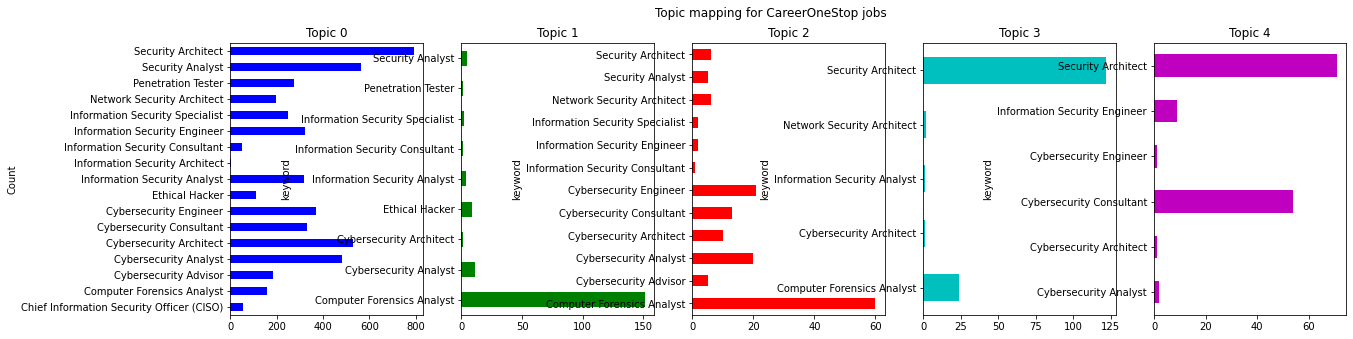

In [276]:
#Barplots showing the job families for each topic
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# plot each series on a different subplot
topic_0.plot.barh(ax=axs[0], color='b')
topic_1.plot.barh(ax=axs[1], color='g')
topic_2.plot.barh(ax=axs[2], color='r')
topic_3.plot.barh(ax=axs[3], color='c')
topic_4.plot.barh(ax=axs[4], color='m')

# set titles and labels for each subplot
axs[0].set_title('Topic 0')
axs[1].set_title('Topic 1')
axs[2].set_title('Topic 2')
axs[3].set_title('Topic 3')
axs[4].set_title('Topic 4')
axs[0].set_ylabel('Count')


# set a title for the figure
fig.suptitle('Topic mapping for CareerOneStop jobs')

# display the plot
plt.show()

In [277]:
pd.DataFrame(topic_1)

,keyword
keyword,
Computer Forensics Analyst,151
Cybersecurity Analyst,11
Cybersecurity Architect,1
Ethical Hacker,9
Information Security Analyst,4
Information Security Consultant,1
Information Security Specialist,2
Penetration Tester,1
Security Analyst,5
